# Long-run performance

In [1]:
import torch
import numpy as np
import scipy.stats
import lp_wealth
from sim_helpers import *
from notebook_helpers import *

In [2]:
num_samples = 1000

sigma = torch.tensor(1.6)
mu = torch.tensor(1.)
gamma = torch.ones(num_samples) * .9

time_step = torch.min(get_max_time_step(gamma, sigma, mu))
num_steps = max(get_min_time_steps(sigma, gamma, time_step), 100000)

sim = lp_wealth.Sim(mu, sigma, gamma, time_step, num_samples)

checkpoints = sim_loop(sim, num_steps, num_checkpoints = num_steps/100)

time = np.array([torch.mean(checkpoint.time) for checkpoint in checkpoints])
amm_wealth = np.array([torch.mean(checkpoint.wealth) for checkpoint in checkpoints])
hodl_wealth = np.array([torch.mean(checkpoint.market_price) for checkpoint in checkpoints])



1 0.0011396408081054688
10001 5.637962341308594
20001 5.33336329460144
30001 5.3840532302856445
40001 5.231883764266968
50001 5.23554253578186
60001 5.244062185287476
70001 5.241990566253662
80001 5.239284515380859
90001 5.268807649612427


Text(0.5, 1.0, 'Mean wealth for HODL vs. Uniswap LP ($\\mu$ = 1.0, $\\sigma$ = 1.6)')

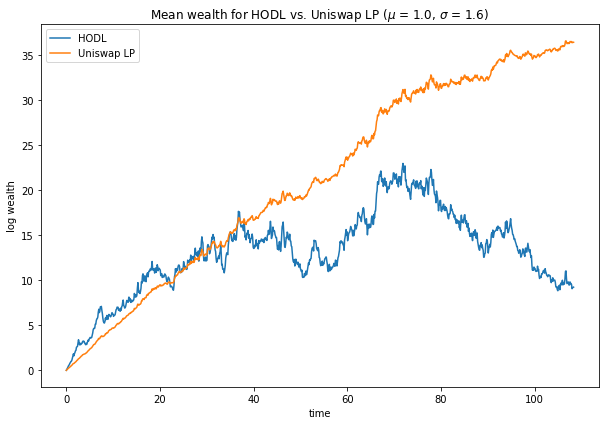

In [3]:
from matplotlib.pyplot import figure
width=10
figure(figsize=(width,width/1.5))
sbn.lineplot(time, np.log(hodl_wealth), label="HODL")
sbn.lineplot(time, np.log(amm_wealth), label="Uniswap LP")
plt.xlabel("time")
plt.ylabel("log wealth")
plt.title(f"Mean wealth for HODL vs. Uniswap LP ($\mu$ = {float(mu)}, $\sigma$ = {round(float(sigma),2)})")
